In [30]:
import numpy as np
import matplotlib.pyplot as pplt
import aicsimage.processing as proc
from aicsimage.io import omeTifReader, pngReader, tifReader, pngWriter
# hides warnings from the tifReader
import warnings
warnings.filterwarnings('ignore')

def show(img, title=""):
    """
    Helper function to display a CYX image
    """
    # flip from CYX to YXC for pyplot
    pplt.imshow(img.transpose(1, 2, 0))
    pplt.title(title)
    pplt.show()
    
def load_all(*files):
    """
    Helper function to return list of images from file paths
    """
    images = []
    for f in files:
        with tifReader.TifReader(f) as r:
            images.append(r.load())
    return images

## Reading files

The aicsimage.io module has several classes for reading and writing images in different formats

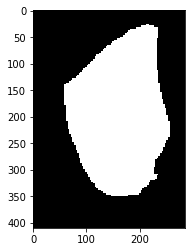

In [31]:
with omeTifReader.OmeTifReader('test/img/img40_1_seg_cell.tif') as r:
    # img is now a greyscale CZYX numpy array
    img = r.load()
    # get midpoint Z slice and duplicate color dim to convert from greyscale to RGB
    img_slice = np.repeat(img[:, img.shape[1] // 2], 3, 0)
    show(img_slice)
    # call the save() function to write a CYX image to a PNG file
    # with pngWriter.PngWriter('test/img/half_slice.png') as w:
        # w.save(img_slice)

## Visualizing structures

In [32]:
# list of test images to use later on
images = load_all("test/sample/20160708_I01_001_1.ome.tif_cell.tif", "test/sample/20160708_I01_001_1.ome.tif_dna.tif", "test/sample/20160708_I01_001_1.ome.tif_memb.tif")
images = proc.crop_all(images)

### imgtoprojection(img, proj_all, proj_method, colors, global_adjust, color_adjust)

 This function can be used to combine multiple greyscale structures into a single projection, using the colors parameter to color each structure.
 
 Below is a typical test case, where multiple greyscale structures are colors and combined into a single XY projection 

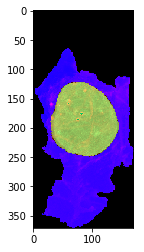

In [33]:
proj = proc.imgtoprojection(images, proj_method="max", colors="jet", local_adjust=True)
# proj can either be shown with matplotlib or written to disk with pngWriter
show(proj)
    

#### Options:

#### img
img can be any of the following:
* A single 4d numpy array as a CZYX image
* A list of 3d numpy arrays as ZYX images (the example above does this)
* A list of 2d numpy array as YX images

Either each channel in the 4d image or each image in the list will be colored by the ```colors``` parameter

#### proj_method
Method used to calculate the projections. Options are:
* max
       The default method, projections are usually bright and vivid
* mean
       Usually shows more detail but many structures may be too faint to see, cropping beforehand is recommended to brighten the images
* sum
       No real reason to use this one, usually gives similar results to mean
* slice
       Uses the middle slice as the projection, quickest to run


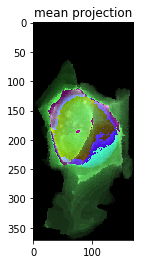

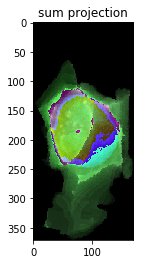

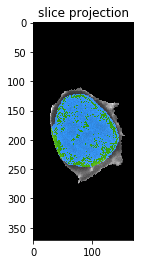

In [34]:
# the cell becomes less bright, but there is odd coloring in the nucleus where all of the
# channels overlap
proj = proc.imgtoprojection(images, proj_method="mean", colors="ocean", local_adjust=True)
show(proj, "mean projection")

# In this case, basically identical to the mean projection
proj = proc.imgtoprojection(images, proj_method="sum", colors="ocean", local_adjust=True)
show(proj, "sum projection")

# Shows the nucleus shape fine, but does not show the real size of the total cell
proj = proc.imgtoprojection(images, proj_method="slice", colors="ocean", local_adjust=True)
show(proj, "slice projection")

#### proj_all
Boolean, default is False. If True, will output the XZ and the YZ projections as well as the XY in a grid

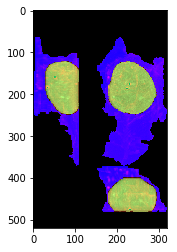

In [35]:
# same example as above, but now shows all three projections
# top left is the YZ projection
# top right is the XY projection
# bottom is the XZ projection
proj = proc.imgtoprojection(images, proj_all=True, colors="jet", local_adjust=True)
show(proj)

#### colors
colors can be one of three types:
* If a string, it will be passed as a parameter to the ```matplotlib.pyplot.get_cmap``` function to get the colors used for the projections. "jet" is a good default, as it will give a smooth rainbow spectrum
* If a function, it must take a single integer as a parameter (corresponding to the 0-based index of the channel to apply the color to) and return a list of three floats in the range of 0-1 to be used as the color for that channel
* If a list, must be a list of lists, which must be 3-element lists of numbers in the range of 0-1 to be used as the color for that channel

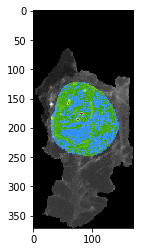

In [36]:
# uses the cmap function "ocean" (blues and greens and greys)
proj_str = proc.imgtoprojection(images, colors="ocean", local_adjust=True)
show(proj_str)

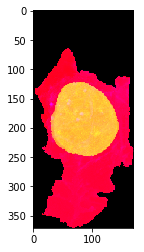

In [37]:
# example color function that cycles through red, blue, and green
def colors_func(i):
    c = [0, 0, 0]
    c[i % 3] = 1
    return c

proj_func = proc.imgtoprojection(images, colors=colors_func, local_adjust=True)
show(proj_func)
# the cell struture is turned red, the dna structure (very faint) is turned blue,
# and the nucleus is turned green (which mixes with the red cell to make yellow)

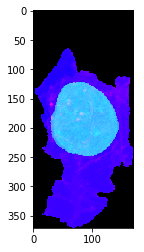

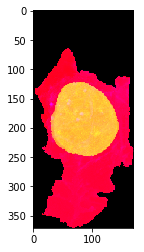

In [38]:
# green, blue, and red
color_list = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]

proj_list = proc.imgtoprojection(images, colors=color_list, local_adjust=True)
show(proj_list)

# notice that the order the images are passed in affects which color is applies to which channel
proj_list = proc.imgtoprojection(images[::-1], colors=color_list, local_adjust=True)
show(proj_list)

#### local_adjust
Boolean value, default is false. If true, will perform contrast adjustment one each channel individually before it is added to the final combined projection. The contrast adjustment consists of subtracting the minimum value from the entire projection and dividing the whole thing by the maximum value.

Although it is off by default, it should be used in most cases, as it seems to dramatically improve image quality

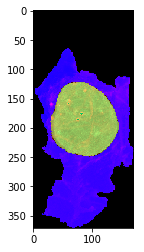

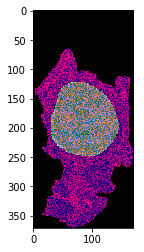

In [39]:
proj_list = proc.imgtoprojection(images, colors="jet", local_adjust=True)
show(proj_list)

# turning local_adjust off usually results in pixelated images
proj_list = proc.imgtoprojection(images, colors="jet", local_adjust=False)
show(proj_list)

## Image Manipulation

In [40]:
with omeTifReader.OmeTifReader("test/sample/20160708_I01_001_1.ome.tif_cell.tif") as r:
    cell = r.load()
with omeTifReader.OmeTifReader("test/sample/20160708_I01_001_1.ome.tif_nuc.tif") as r:
    nuc = r.load()
    
cell, nuc = proc.crop_all([cell, nuc])

### Rotation

Use ```align_major``` to rotate a 3d structure to align with an axis

The ```axis``` parameter is a string which specifies which axis to align the structure to. The major axis will be aligned to the first one in the string, and the minor will be aligned to the last one. In the example below, with the parameter "xyz", the major is aligned to the x axis, and the minor is aligned to the z axis

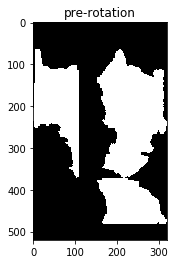

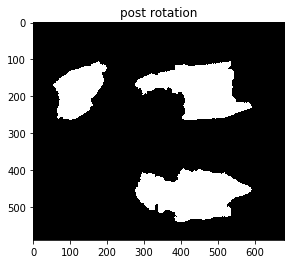

In [41]:
proj = proc.imgtoprojection(cell, proj_all=True)
show(proj, "pre-rotation")

# use the 'axis' parameter to choose which axis to align the structure to
cell_rot, angles = proc.align_major(cell, axis="xyz", reshape=True)
proj = proc.imgtoprojection(cell_rot, proj_all=True)
show(proj, "post rotation")

The ```reshape``` parameter is a boolean, false by default. When true, it will reshape the output image in order to ensure that none of the data from the input image is lost. If false, the output image will be the same shape as the input image, but there is a good chance of cropping out important data.

Notice that the function returned two objects. The first is the rotated structure, and the second is a tuple of the angles used to rotate the image. This can be passed to future calls of this function to rotate multiple structures by the same amount

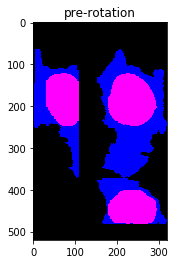

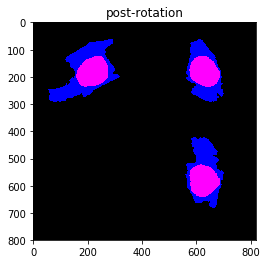

In [42]:
proj = proc.imgtoprojection([cell[0], nuc[0]], colors="jet", proj_all=True, local_adjust=True)
show(proj, "pre-rotation")

cell_rot, angles = proc.align_major(cell, axis="zyx", reshape=True)
# now use the angles to rotate another structure by the same amount
# the function only returns the rotated structure if you pass in the angles as a parameter
nuc_rot = proc.align_major(nuc, angles=angles, reshape=True)

proj_rot = proc.imgtoprojection([cell_rot[0], nuc_rot[0]], colors="jet", proj_all=True, local_adjust=True)
show(proj_rot, "post-rotation")

The cell is rotated to align with the z axis, and the nucleus is rotated by the same amount to keep the two structures aligned with each other

### Centering
Use ```center_image``` to center an image based on its center of mass.
It does this by padding the image, so the output image will always be larger than the input (unless no padding is needed)

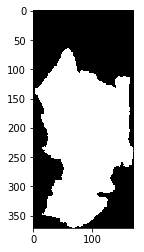

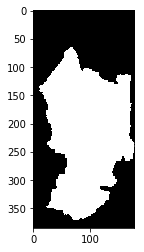

In [43]:
from scipy.ndimage.measurements import center_of_mass as com
proj = proc.imgtoprojection(cell)
show(proj)

# both the centered image and the moves needed to center it are returned
# this particular structure was already nearly centered
cell_cent, moves = proc.center_image(cell)
proj_cent = proc.imgtoprojection(cell_cent)
show(proj_cent)

Similar to ```align_major```, the function returns the moves needed to center the structure. This can be passed to future function calls in order to move multiple structures by the same amount

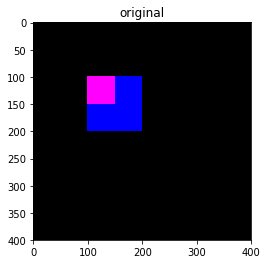

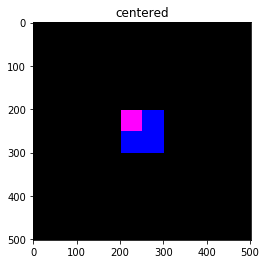

In [44]:
# example structures
big = np.zeros((1, 400, 400))
big[0, 100:200, 100:200] = 1
little = np.zeros((1, 400, 400))
little[0, 100:150, 100:150] = 1
proj = proc.imgtoprojection([big, little], colors="jet", local_adjust=True)
show(proj, "original")

# center by the big structure, move the little structure along with it
big_cent, moves = proc.center_image(big)
# similar to align_major, the function does not return the moves if you pass them in
little_cent = proc.center_image(little, moves=moves)
proj_cent = proc.imgtoprojection([big_cent, little_cent], colors="jet", local_adjust=True)
show(proj_cent, "centered")

The centered structures appear smaller because the centered image is bigger due to the added padding

The ```axis``` parameter allows for the image to only be centered along certain axis. By default, the function will center align the last 3 axis of the passed in image (meant to be the Z, Y, and X axis). This can be used to only align along certain axis, like if you want it centered in the X and Y axis but not Z, or if you want to center an image with a different format, like a XYC image instead of a CZYX.

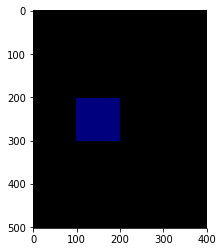

In [45]:
# same structure from previous example, only centered on Z and Y axis
big_cent, moves = proc.center_image(big, axis=(0, 1))
proj = proc.imgtoprojection([big_cent], colors="jet")
show(proj)

### Cropping

Since centering an image adds padding, cropping afterwards is usually recommended. The ```crop_all``` is the best way to do this after centering. It is meant to crop a group of images by the same amount, removing an equal amount from both ends of each axis that it crops on to ensure that the structures are still centered

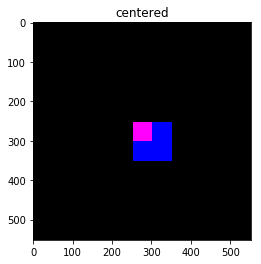

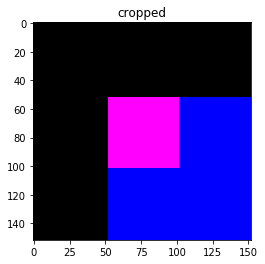

In [46]:
# centering by the little structure this time
little_cent, moves = proc.center_image(little)
big_cent = proc.center_image(big, moves=moves)
proj = proc.imgtoprojection([big_cent, little_cent], colors="jet", local_adjust=True)
show(proj, 'centered')


big_cropped, little_cropped = proc.crop_all([big_cent, little_cent])
proj_cropped = proc.imgtoprojection([big_cropped, little_cropped], colors="jet", local_adjust=True)
show(proj_cropped, "cropped")

The function cropped as much as it could without changing the center of mass or removing any data from either structure. The ```crop_all``` function also takes an ```axis``` parameter which lets it crop along any axis. By default, just like ```center_image```, it will act along the last 3 axis

If you do not care about keeping a structure centered, the ```crop``` function will crop off as much as it can from a  single image, with the option to leave some padding

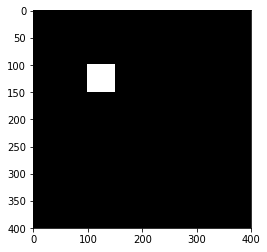

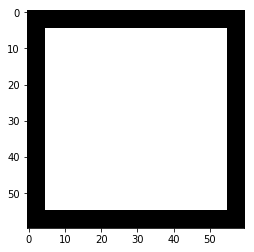

In [52]:
show(proc.imgtoprojection([little]))

little_crop = proc.crop(little, padding=5)

show(proc.imgtoprojection([little_crop]))

All but 5 pixels of padding was cropped from the image

### Background Subtraction
The processing library comes with some very basic background subtraction methods